# [Lecture 02 - The Garden of Forking Data](https://youtu.be/R1vcdhPBlXA?si=rL3BOz9hHxkPt79m)

In [1]:
%run init_notebook.py

Module aliases imported by init_notebook.py:
--------------------------------------------
import numpy as np

import pandas as pd

import statsmodels.formula.api as smf

import pymc as pm

import xarray as xr

import arviz as az

import utils as utils

from scipy import stats as stats

from matplotlib import pyplot as plt

Watermark:
----------
Last updated: 2024-03-21T00:41:23.073530-05:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.15.0

Compiler    : Clang 15.0.7 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

pandas     : 2.1.0
scipy      : 1.11.2
pymc       : 5.8.0
xarray     : 2023.8.0
numpy      : 1.25.2
arviz      : 0.16.1
matplotlib : 3.7.2
statsmodels: 0.14.0



# Task: What proportion of earth's surface is covered with water?

## Bayesian Workflow (Drawing the Owl)

1. Define generative model of tossing the globe
2. Define an estimand -- in this case, the proportion of globe covered in water?
3. Design a statistical means to produce estimate
4. Test (3) using (2)
5. Analyze real data

### 1, 2. Define generative model of globe tossing
- $p$: proportion of water -- this is what we d like to estimate
- $N$: number of tosses  -- we control this via experiment
- $W$: number of Water observations
- $L$: number of Land observations

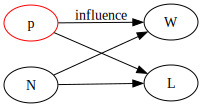

In [2]:
utils.draw_causal_graph(
    edge_list=[
        ("p", "W"),
        ("p", "L"),
        ("N", "L"),
        ("N", "W")
    ],
    graph_direction="LR",
    node_props={
        "p": {"color": "red"}
    },
    edge_props={
        ("p", "W"): {"label": "influence"}
    }
)

- This graph defines a causal model of how $p, N$ effect the values of $W, L$.
- This is the same as saying it defines some function $f$ that maps $p, N$ onto the values of $W, L \rightarrow$  $W, L = f(p, N)$
- Scientific knowledge defines what $f$ is or can be

#### Bayesian data analysis
"Very simple, very humble"
- For each possible explanaint of the sample
- Count all the ways the sampel could occur
- **The explanations with the largest number of ways to produce the sample are more plausible**

The unglamourous basis of applied probability:
> Things that can happen more ways are more plausible.


## 3. Design a statistical way to produce estimate
### Garden of Forking Data
Following the mantra above...

- for each possible **proportion of water**, $p$
- count all the ways the sample of tosses could have occurred
- the $p$ that are associated with more ways to produce the sample are more plausible


In [3]:
def calculate_n_ways_possible(observations: str, n_water: int, resolution: int = 4):
    """
    Calculate the number of ways to observing water ('W') given the toss of a globe
    with `resolution` number of sides and `n_water` faces.
    Note: this method results in numerical precision issues (due to the product) when the
    resolution of 16 or so, depending on your system.
    """
    assert n_water <= resolution  # check for fewer water faces than total faces
    
    # Convert observation string to an array
    observations = np.array(list(observations.upper()))
    # Create n-sided globe with possible outcomes
    n_land = resolution - n_water
    possible = np.array(list("L" * (n_land)) + list("W" * n_water))
    
    # Given possible w-l config, tally number of ways sample could have been collected at each iteration of observation
    # Here we use brute-force, but we could also use the analytical solution below
    ways = []
    for obs in observations:
        ways.append((possible == obs).sum())
        
    p_water = n_water / resolution
    # perform product of array elements to get number of combo --- done in log space for numerical precision
    n_possible_ways = np.round(np.exp(np.sum(np.log(ways)))).astype(int)
    return n_possible_ways, p_water



def run_globe_tossing_simulation(observations, resolution, current_n_possible_ways=None):
    """
    Simulate the number of ways you can observe water ('W') for a globe of `resolution`
    sides, looping through variations of globes with water face.
    """
    # For Bayesian updates
    current_n_possible_ways = current_n_possible_ways if current_n_possible_ways is not None else np.array([])

    print(f"Observations: '{observations}'")
    current_p_water = np.array([])
    for n_W in range(0, resolution + 1):
        n_L = resolution - n_W
        globe_sides = "W" * n_W + "L" * n_L
        n_possible_ways, p_water = calculate_n_ways_possible(observations, n_water=n_W, resolution=resolution)
        print(f"({n_W+1}) {globe_sides} p(W) = {p_water:1.2}  \t\t  {n_possible_ways} Ways to Produce")

        current_p_water = np.append(current_p_water, p_water)
        current_n_possible_ways = np.append(current_n_possible_ways, n_possible_ways)

    return current_n_possible_ways, current_p_water


RESOLUTION = 4
observations = "WLW"
current_n_possible_ways, current_p_water = run_globe_tossing_simulation(observations, resolution=RESOLUTION)

Observations: 'WLW'
(1) LLLL p(W) = 0.0  		  0 Ways to Produce
(2) WLLL p(W) = 0.25  		  3 Ways to Produce
(3) WWLL p(W) = 0.5  		  8 Ways to Produce
(4) WWWL p(W) = 0.75  		  9 Ways to Produce
(5) WWWW p(W) = 1.0  		  0 Ways to Produce


## Bayesian (online) Updating

In [4]:
new_observation_possible_ways, _ = run_globe_tossing_simulation("W", resolution=RESOLUTION)

# Online update: multiply old * new combo number
current_n_possible_ways *= new_observation_possible_ways

print("\nUpdated Possibilities given new observation:")
for ii in range(0, RESOLUTION + 1):
    print(f"({ii+1}) p(W) = {current_p_water[ii]:1.2}\t\t{int(current_n_possible_ways[ii])} Ways to Produce")


Observations: 'W'
(1) LLLL p(W) = 0.0  		  0 Ways to Produce
(2) WLLL p(W) = 0.25  		  1 Ways to Produce
(3) WWLL p(W) = 0.5  		  2 Ways to Produce
(4) WWWL p(W) = 0.75  		  3 Ways to Produce
(5) WWWW p(W) = 1.0  		  4 Ways to Produce

Updated Possibilities given new observation:
(1) p(W) = 0.0		0 Ways to Produce
(2) p(W) = 0.25		3 Ways to Produce
(3) p(W) = 0.5		16 Ways to Produce
(4) p(W) = 0.75		27 Ways to Produce
(5) p(W) = 1.0		0 Ways to Produce


## The whole sample

In [5]:
RESOLUTION = 4
observations = "WLWWWLWLW"
n_W = len(observations.replace("L", ""))
n_L = len(observations) - n_W

n_possible_ways, p_water = run_globe_tossing_simulation(observations, resolution=RESOLUTION)

Observations: 'WLWWWLWLW'
(1) LLLL p(W) = 0.0  		  0 Ways to Produce
(2) WLLL p(W) = 0.25  		  27 Ways to Produce
(3) WWLL p(W) = 0.5  		  512 Ways to Produce
(4) WWWL p(W) = 0.75  		  729 Ways to Produce
(5) WWWW p(W) = 1.0  		  0 Ways to Produce


show that we get identical answers with the analytical solution

#### Combinatorics result suggested the Analytical Estimator
n ways of the sampled $ W,L =  (Rp)^W \times (R - Rp)^L$, where   

$p$ is the probability/ proportion of water in a given resolution number of faces of the earth

$R$ is the number of possible globes (4 for our case)

In [6]:
def calculate_analytic_n_ways_possible(p, n_W, n_L, resolution=RESOLUTION):
    """This scales much better than the brute-force method"""
    analytic_n_possible_ways = (resolution * p) ** n_W * (resolution - resolution * p) ** n_L
    return analytic_n_possible_ways

analytic_n_possible_ways = np.array([calculate_analytic_n_ways_possible(p, n_W, n_L) for p in p_water])

print(analytic_n_possible_ways)
print(analytic_n_possible_ways == n_possible_ways)  # comparing n ways generated from from the analytic model vs combonatoric simulation at each of the 4 p values

[  0.  27. 512. 729.   0.]
[ True  True  True  True  True]


## Probability
- non-negative values that sum to 1
- normalizes large sums by the total counts

Proportion	Ways	Probability
0.0		0	0.00
0.25		27	0.02
0.5		512	0.40
0.75		729	0.57
1.0		0	0.00


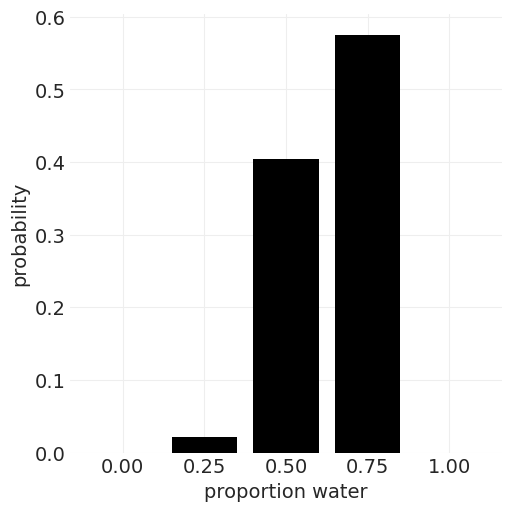

In [7]:
n_possible_probabilities = n_possible_ways / n_possible_ways.sum()

print("Proportion\tWays\tProbability")
for p, n_w, n_p in zip(p_water, n_possible_ways, n_possible_probabilities):
    print(f"{p:1.12}\t\t{n_w:0.0f}\t{n_p:1.2f}")

# Histogram
p_water = np.linspace(0, 1, RESOLUTION+1)
plt.subplots(figsize=(5, 5))
plt.bar(x=p_water, height=n_possible_probabilities, width= 0.8 / RESOLUTION, color='k')
plt.xticks(p_water);
plt.ylabel("probability")
plt.xlabel("proportion water");

## 4. Test (3, estimator) using (1, samples)

### Test Before You Est(imate) 🐤
1. Code generative simulation
2. Code an estimator
3. Test 2 with 1; you should get expected output

**IF YOU TEST NOTHING YOU MISS EVERYTHING**



### 4.1 Generative Simulation

In [8]:
from pprint import pprint


np.random.seed(1)
def simulate_globe_toss(p=0.7, N=9):
    """Simulate N globe tosses with a specific/known proportion
    p: float -> The propotion of water
    N: int   -> Number of globe tosses
    """
    return np.random.choice(list("WL"),  size=N, p=np.array([p, 1-p]), replace=True)


print(simulate_globe_toss())

['W' 'L' 'W' 'W' 'W' 'W' 'W' 'W' 'W']


In [9]:
samples = [simulate_globe_toss(p=.5, N=10).tolist() for _ in range(10)]  # change p to test extreme conditions
pprint(samples)

[['L', 'W', 'L', 'W', 'L', 'W', 'L', 'W', 'L', 'W'],
 ['W', 'L', 'L', 'W', 'L', 'L', 'L', 'W', 'W', 'W'],
 ['L', 'W', 'W', 'L', 'L', 'L', 'W', 'L', 'L', 'W'],
 ['L', 'L', 'L', 'W', 'L', 'W', 'W', 'L', 'W', 'W'],
 ['W', 'W', 'L', 'W', 'W', 'W', 'W', 'L', 'W', 'L'],
 ['L', 'W', 'W', 'L', 'W', 'W', 'L', 'L', 'L', 'L'],
 ['L', 'L', 'W', 'W', 'L', 'W', 'W', 'L', 'W', 'L'],
 ['L', 'L', 'L', 'L', 'W', 'W', 'L', 'W', 'L', 'L'],
 ['L', 'W', 'L', 'W', 'L', 'W', 'W', 'L', 'L', 'W'],
 ['L', 'W', 'L', 'L', 'W', 'L', 'L', 'W', 'L', 'L']]


#### Test on Extreme settings

0.3
0.49865107913669066
0.4979757085020243
0.49973005398920217
0.49923509561304835
0.4986321094312455
0.5006449677516124
0.5016070969400874
0.49940375745303184
0.50033


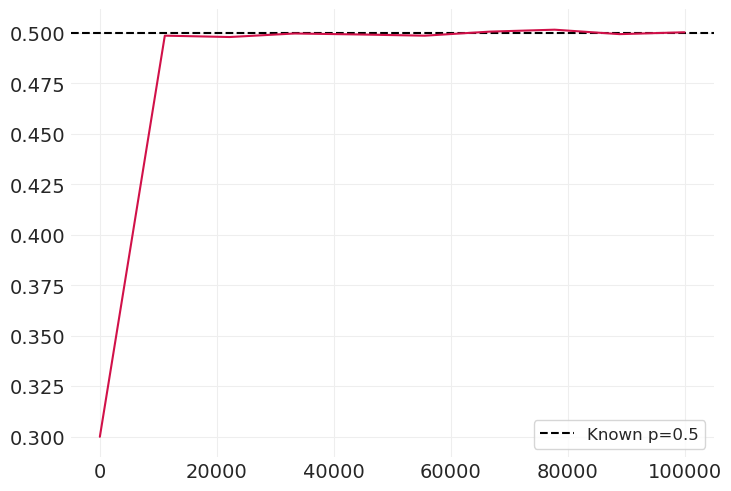

In [10]:
# Large N should converge to known p
known_p = 0.5

simulated_ps = []
sample_sizes = np.linspace(10, 100_000, 10)
for N in sample_sizes:
    outcomes = simulate_globe_toss(p=known_p, N=int(N))
    simulated_p = np.sum(outcomes == 'W') / N
    print(simulated_p)
    simulated_ps.append(simulated_p)
    
plt.axhline(known_p, label=f"Known p={known_p}", color='k', linestyle='--')
plt.legend();
plt.plot(sample_sizes, simulated_ps);

### 4.2 Code the estimator

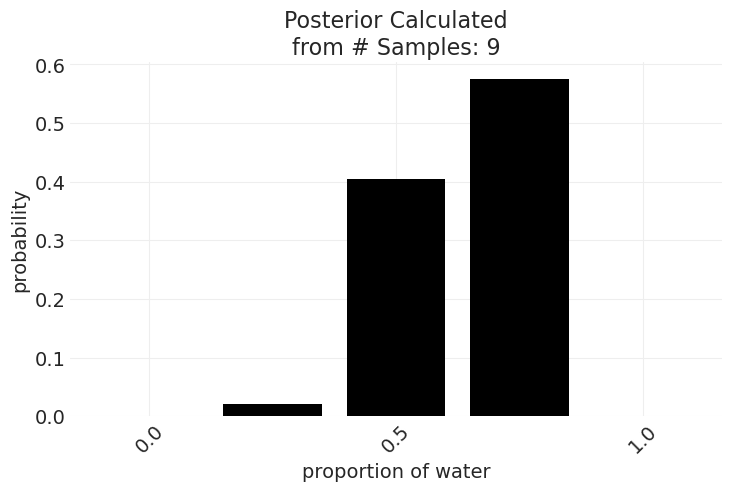

In [11]:
def compute_posterior(observations, resolution=RESOLUTION):
    """
    fn apply the analytic way of calculating n ways of arriving at the obs given each p_water and resolution # of faces
    """
    n_W = len(observations.replace("L", ""))
    n_L = len(observations) - n_W
    
    p_water = np.linspace(0, 1, resolution+1)
    n_possible_ways = np.array([calculate_analytic_n_ways_possible(p, n_W, n_L, resolution) for p in p_water])
    posterior = n_possible_ways / n_possible_ways.sum()
    # probs = np.linspace(0, 1, resolution+1)
    return posterior, p_water


def plot_posterior(observations, resolution=RESOLUTION, ax=None):
    """
    Plotting proportion of water, and their probability of occuring in an earth with resolution # of faces
    """
    posterior, p_water = compute_posterior(observations, resolution=resolution)
    if ax is not None:
        plt.sca(ax)
    plt.bar(x=p_water, height=posterior, width= .8 / resolution, color='k')
    plt.xticks(p_water[::2], rotation=45);
    plt.ylabel("probability")
    plt.xlabel("proportion of water")
    plt.title(f"Posterior Calculated\nfrom # Samples: {len(observations)}")
    return posterior, p_water


observations = "WLWWWLWLW"
posterior, p_water = plot_posterior(observations, resolution=4)

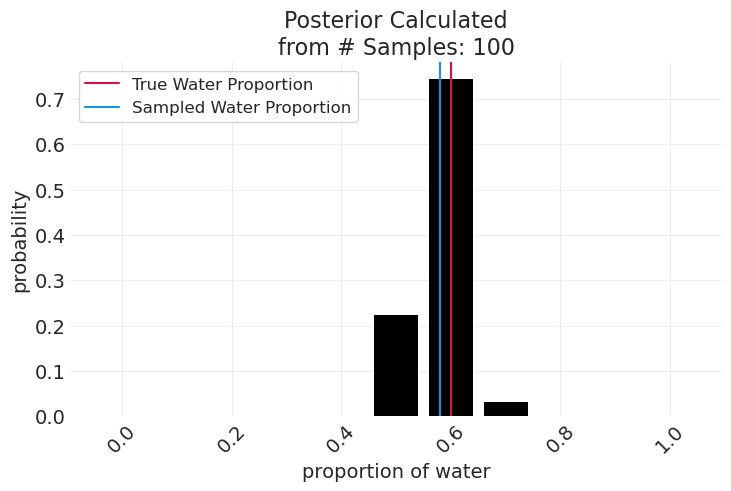

In [12]:
resolution=10
p = .6
N = 100

# Given a p and known resolution, simulate sampling of N obs
# np.random.seed(2) # seed fix random generator
simulated_observations = "".join(simulate_globe_toss(p=p, N=N))  # converting array into string for input into plot_posterior fN
sampled_n_water = len(simulated_observations.replace("L", ""))/N

# Pass sample and resolution (p kept hidden) into fN using analytic estimator to calculate posterior probability of various p_water
posterior, p_water = plot_posterior(simulated_observations, resolution)
plt.axvline(p, color='C0', label='True Water Proportion')
plt.axvline(sampled_n_water, color='C1', label='Sampled Water Proportion')
plt.legend();

# -> most likely p_water to have generatered the sample is p_water with highest probability

## Infinite Possibilities

### Moving from an N-sided globe to an infinitely-sided globe.
As we increase resolution of globe
- there are more bars/finer-grained resolution along the proportion axis
- bars get shorter with more possibilities -- they must sum to 1

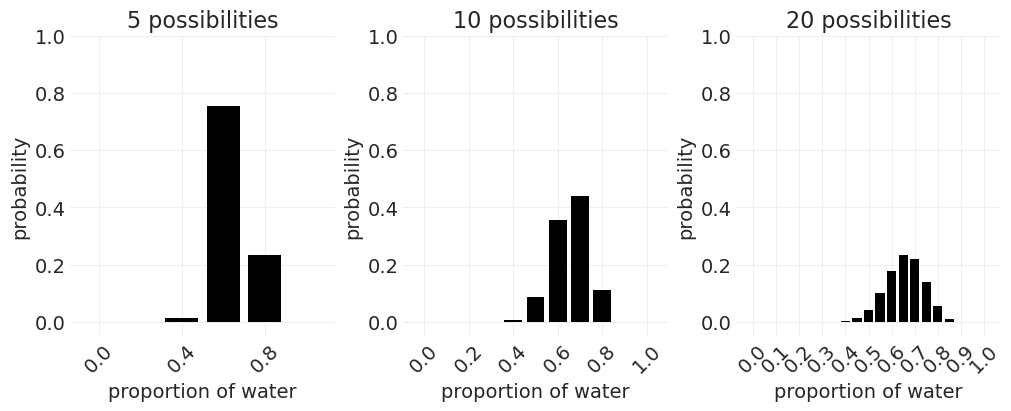

In [13]:
np.random.seed(12)
p = .7
simulated_observations = "".join(simulate_globe_toss(p=p, N=30))
_, axs = plt.subplots(1, 3, figsize=(10, 4))
for ii, possibilities in enumerate([5, 10, 20]):
    plot_posterior(simulated_observations, resolution=possibilities, ax=axs[ii])
    plt.ylim([-.05, 1])
    axs[ii].set_title(f"{possibilities} possibilities")

### Beta Distribution

Analytical function that gives us the pdf as the limit as number of possibilities $\rightarrow \infty$

$$
p = \frac{(W + L + 1)!}{W!L!} p^W(1-p)^L
$$

where $\frac{(W + L + 1)!}{W!L!}$ is a normalizing constant to make the distribution sum to 1



### Tossing the Globe

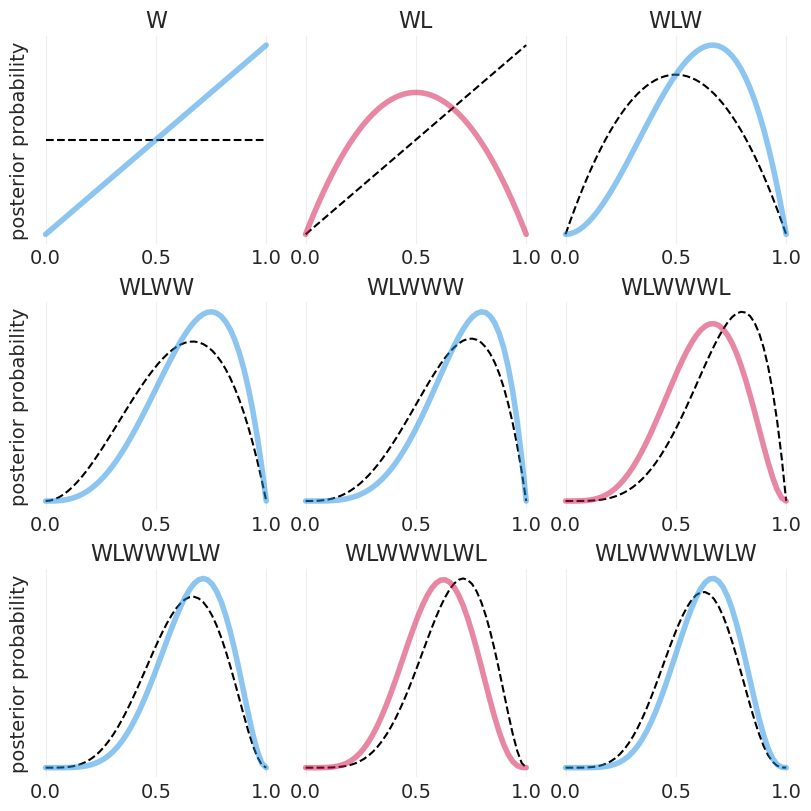

In [60]:
from scipy.special import factorial

# Estimator based on the beta distribution
def beta(W, L, p):
    return factorial(W + L + 1) / (factorial(W) * factorial(L)) * p ** W * (1-p) ** L


def plot_beta_from_observations(observations: str, resolution: int = 50, **plot_kwargs):
    """Calcualte the posterior for a string of observations"""
    n_W = len(observations.replace("L", ""))
    n_L = len(observations) - n_W
    proportions_water = np.linspace(0, 1, resolution)
        
    posterior_p = beta(n_W, n_L, proportions_water)
    plt.plot(proportions_water, posterior_p, **plot_kwargs)
    plt.yticks([])
    plt.title(observations)
    

# Tossing the globe
observations = "WLWWWLWLW"
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
for ii in range(9):
    ax = axs[ii // 3][ii % 3]
    plt.sca(ax)
    
    # Plot previous posterior distribution as dash
    if ii > 0:
        plot_beta_from_observations(observations[:ii], color='k', linestyle='--')
    else:  # First observation, no previous data
        plot_beta_from_observations('', color='k', linestyle='--')

    # Plot updated posterior distr as solid line
    color = 'C1' if observations[ii] == 'W' else 'C0'  # blue line if new obs is W
    plot_beta_from_observations(observations[:ii+1], color=color, linewidth=4, alpha=.5)
    
    if not ii % 3:
        plt.ylabel("posterior probability")
    

## On Bayesian Inference...
- **There is no minimun sample size** -- fewer samples fall back to prior
- **Posterior shape embodies the sample size** -- more data makes the posterior more precise
- There is no point estimates -- **the estimate is the entire posterior distribution**
- There is no true interval -- there are an infinite number of intervals one could draw, each is arbitrary and depends on what you're trying to communicate/summarize

## From Posterior to Prediction
- To make predictions, we must average (i.e. integrate) over the entire posterior -- this averages over the uncertainty in the posterior
- We could do this with integral calculus
- OR, we could **just take samples from the posterior and average over those**

**TURN A CALCULUS PROBLEM INTO A DATA SUMMARY PROBLEM**

### Sampling from Posterior Distribution

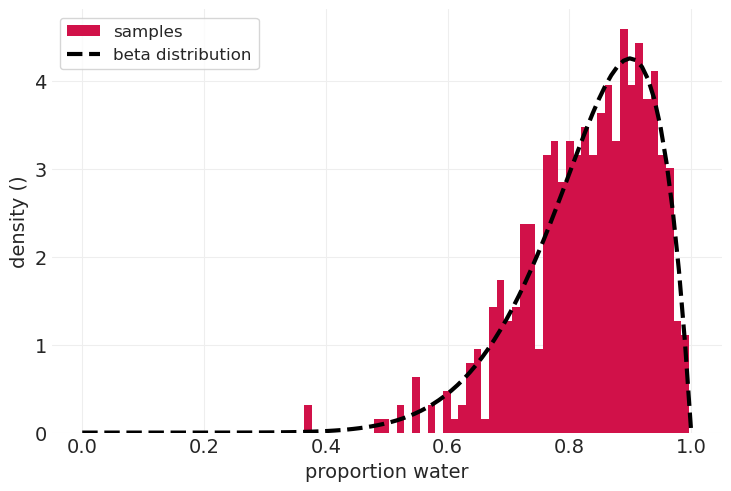

In [57]:
a, b = 9, 1 # a = n_water; b = n_land

# sampling the posterior, a beta destribution
beta_posterior = stats.beta(a+1, b+1)  #  +1 since the beta equation used by stat has a 'a-1' exponent that our manual equations has taken down and replaced as 'a' (same for 'b')
bets_posterior_samples = beta_posterior.rvs(size=500)
plt.hist(bets_posterior_samples, bins=50, density=True, label='samples');

# ideal Beta distribution
p_water = np.linspace(0, 1, 100)
plt.plot(p_water, beta(a, b, p_water), linewidth=3, color='k', linestyle='--', label='beta distribution')  # Beta defined manually earlier

plt.xlabel("proportion water")
plt.ylabel("density ()")
plt.legend();

### Sampling from Posterior Predictive Distribution
**Posterior Prediction**: a prediction for out-of-sample data based on the current posterior estimate

The **Posterior Predictive Distribution** is a weighted average of sampling at all p values from the posterior distribution. Weighting is done by generating the p values from sampling the posterior distribution itself. This way, p with higher prob would get sampled more often, and is represented in higher frequency (=> greater weight).

By conducting sampling for p, and the proportion of water: land for each p, we capture both degrees of uncertainty.

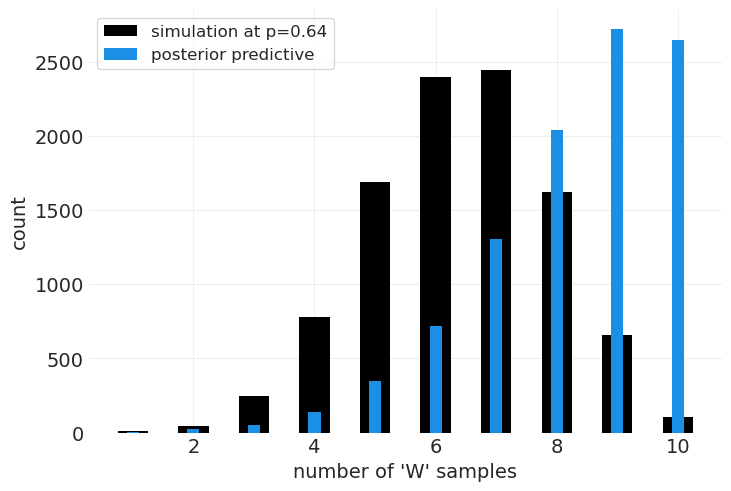

In [16]:
# 1. Sampling p's from the posterior distribution
posterior_samples = beta_posterior.rvs(size=10000)

# 2. Here we use each sampled p from the posterior to simulate sampling 10 observations from our generative model
posterior_predictive = [(simulate_globe_toss(p, 10) == 'W').sum() for p in posterior_samples]
ppd_unique, ppd_counts = np.unique(posterior_predictive, return_counts=True)

# Sampling with a p in the  beta distribution - for contrast with when p is sampled, rather than selected
specific_prob = 0.64
specific_predictive = [(simulate_globe_toss(specific_prob, 10) == 'W').sum() for _ in posterior_samples]
specific_unique, specific_counts = np.unique(specific_predictive, return_counts=True)

plt.bar(specific_unique, specific_counts, width=.5, color='k', label=f'simulation at p={specific_prob:1.2}');
plt.bar(ppd_unique, ppd_counts, width=.2, color='C1', label='posterior predictive');
plt.xlabel("number of 'W' samples")
plt.ylabel('count')
plt.legend();


### Sampling is Handsom & Handy
Things we'll compute via sampling
- Forecasts
- Causal effects
- Counterfactuals
- Prior Predictions

# Summary: Bayesian Data Analysis
- For each possible explanation of data
- Count all the ways that data could happen under that explanation
- The explanations with more ways to produce data are more plausable

## Bayesian Modesty
- If your generative model is correct, you can't do better: this will be an optimal
- givens no gaurantees, only provides what you put into it

# Bonus: Misclassification
In previous examples, we  do not consider sampling error or noise in measurement. In other words the number of Water observations that we measure may not be the _true_ number value. This means that the _true_ value for $W$ is unknown / unmeasured, but we instead measure $W^*$ that is a cause of the true, unmeasured $W$ and the measurement process M. If we know our measurement error rate, we can attempt to model it

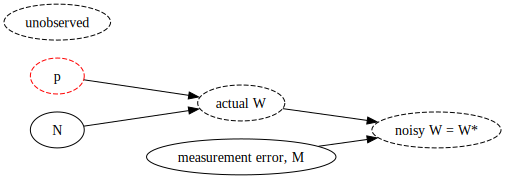

In [18]:
utils.draw_causal_graph(
    edge_list=[
        ("p", "W"),
        ("W", "W*"),
        ("M", "W*"),
        ("N", "W")
    ],
    node_props={
        "p": {"color": "red", "style": "dashed"},
        "W": {"style": "dashed", "label": "actual W"},
        "W*": {"style": "dashed", "label": "noisy W = W*"},
        "unobserved": {"style": "dashed"},
        "M": {"label": "measurement error, M"}
    },
    graph_direction="LR"
)

## Missclassification Simulation

In [28]:
def simulate_noisy_globe_toss(p=0.7, N=9, error_rate=0.1):
    # True sample
    sample = np.random.choice(list("WL"),  size=N, p=np.array([p, 1-p]), replace=True)
    
    # Error-induced sample
    error_trials = np.random.rand(N) < error_rate
    errors_effect_sample_trials = (sample == 'W') & error_trials
    sample[errors_effect_sample_trials] = 'L'
    return error_trials, sample
    
simulate_noisy_globe_toss()

(array([False,  True, False, False, False, False, False, False, False]),
 array(['W', 'L', 'L', 'W', 'W', 'W', 'W', 'L', 'L'], dtype='<U1'))

## Missclassification Estimator

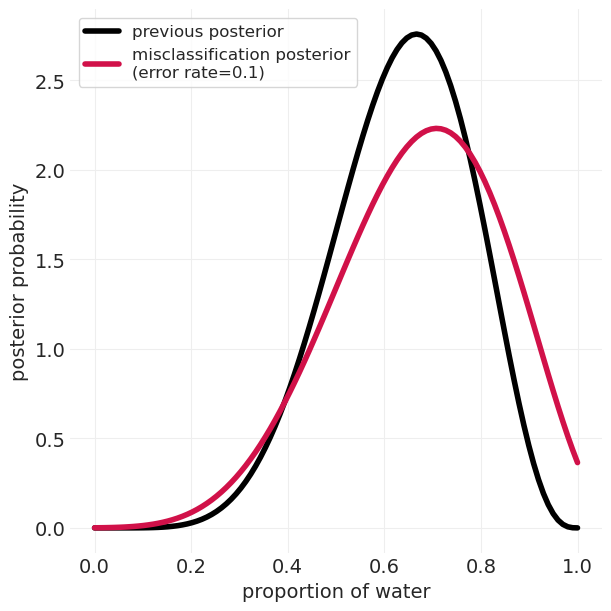

In [49]:
def calculate_unnormalized_n_ways_possible_with_error(p, n_W, n_L, error_rate=0.1):
    n_W_error = (p * (1 - error_rate) + ((1 - p) * error_rate)) ** n_W 
    n_L_error = ((1 - p) * (1 - error_rate) + (p * error_rate)) ** n_L
    return n_W_error * n_L_error

a, b = 6, 3
resolution = 100
proportions = np.linspace(0, 1, resolution)
error_rate = 0.1
error_posterior = np.array(
    [calculate_unnormalized_n_ways_possible_with_error(p, a, b, error_rate) for p in proportions]
)

beta_posterior = beta(a, b, proportions)

# Infer normalization constant Z from distribution
error_posterior *= resolution / error_posterior.sum()
beta_posterior *= resolution / beta_posterior.sum()



plt.subplots(figsize=(6, 6))
plt.plot(proportions, beta_posterior, label='previous posterior', color='k', linewidth=4)
plt.plot(proportions, error_posterior, label=f'misclassification posterior\n(error rate={error_rate:1.2})', linewidth=4)
plt.xlabel("proportion of water")
plt.ylabel("posterior probability")
plt.legend();

## Measurement Matters
- beter to model measurement error, than to ignore it
- same goes for mssing data
- what matters is _why_ samples differ, and that we are explicit about how model it